# NLP & W2VEC

In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


In [2]:
data = pd.read_csv("./data/data1663129938.csv")
data = data[['message', 'category']]

In [3]:
data.head()

,message,category
0,อ่าาาาา,C
1,ใช่ปี4ทั้ง2เทอม เป็นproject,S
2,หรือเทอมนี้แล้ว,S
3,แสดงว่าเทอมหน้าก็ธีซิสช่ะ,S
4,อ๋อออออ,C


### Data Features and Values

In [4]:
category_list = data['category'].unique()
category_list

array(['C', 'S', 'Q', 'T', 'A'], dtype=object)

In [5]:
def clean_data(data):
    # sort data by category
    data = data.sort_values(by=['category'])

    data = data.reset_index()
    data = data[['message', 'category']]

    return data

In [6]:
data = clean_data(data= data)

In [7]:
data.shape

(367, 2)

In [8]:
data.dtypes

message     object
category    object
dtype: object

In [9]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

In [10]:
def plot_count_graph():
    count_graph = sns.countplot(data.category)
    count_list = []

    for p in count_graph.patches:
        height = p.get_height()
        count_list.append(height)
        count_graph.annotate('{:.1f}'.format(height), (p.get_x()+0.25, height+0.01))

    plt.show()

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


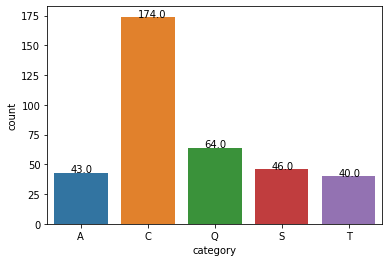

In [11]:
plot_count_graph()

### Balancing Category

In [12]:
df_list = []
for category in category_list:
    df_list.append(data.query(f"category == '{category}'").sample(
        n=40,
        replace=False, #True if numbers of sample higher than minimum numbers of category
        random_state=18, 
        )
    )

data = clean_data(data= pd.concat(df_list))

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


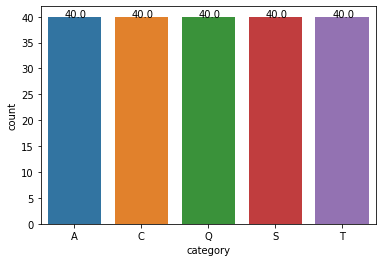

In [13]:
plot_count_graph()

In [14]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0       24
1       80
2       68
3       49
4       43
      ... 
195     39
196    420
197     91
198     26
199     30
Name: message_length, Length: 200, dtype: int64


### Words Distribution Plot

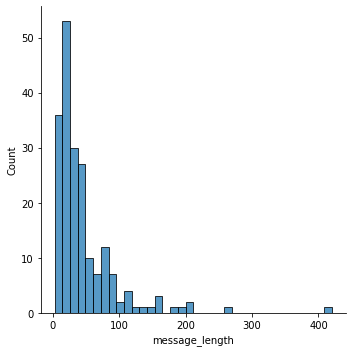

In [15]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [16]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [17]:
words_category = []
for category in category_list:
    words_category.append(count_words(category))

words_category

[141, 251, 213, 283, 227]

In [18]:
print('Total Word:')
print(count_words())

Total Word:
672


<AxesSubplot:xlabel='category', ylabel='words_count'>

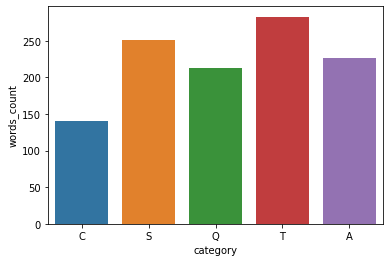

In [19]:
words_count = {'category': category_list, 'words_count': words_category}
w_count_data = pd.DataFrame(words_count)
sns.barplot(x= 'category', y='words_count', data=w_count_data)

### Word Cloud

In [20]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [21]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

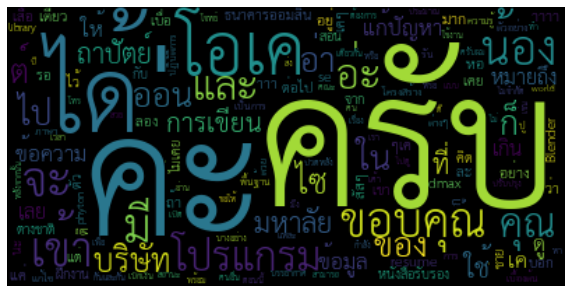

In [22]:
check_wordcloud('C')

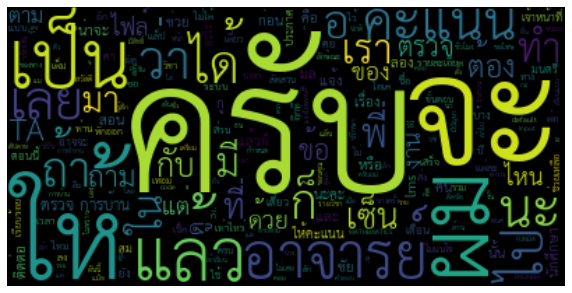

In [23]:
check_wordcloud('T')

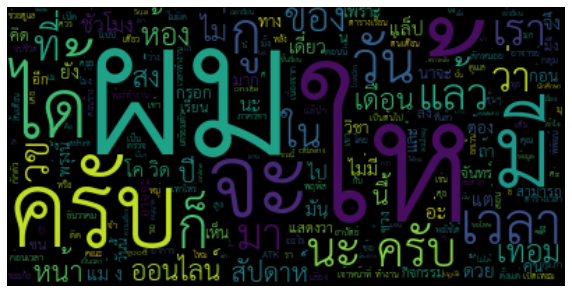

In [24]:
check_wordcloud('S')

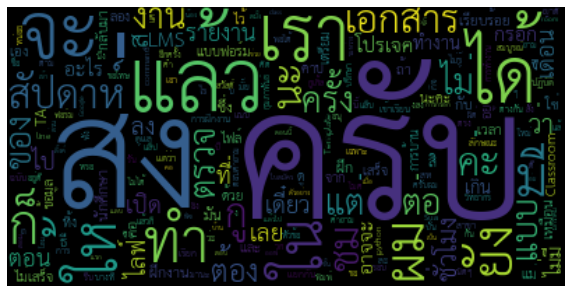

In [25]:
check_wordcloud('A')

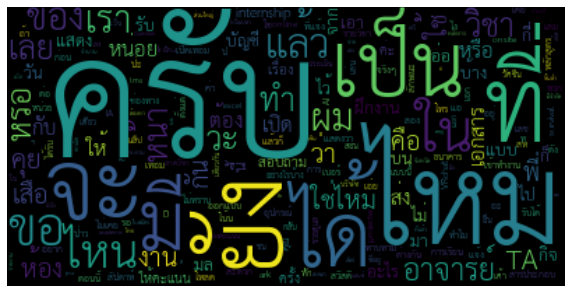

In [26]:
check_wordcloud('Q')

### Label Encoding

In [27]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [28]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)

    category  category_target
0          A                0
40         C                1
80         Q                2
120        S                3
160        T                4


In [29]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")

# Writing to .json
with open("classes.json", "w") as outfile:
    outfile.write(json_classes)


   


In [30]:
# Opening JSON file
with open('classes.json', 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [31]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [32]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'C', 'Q', 'S', 'T']


### Word2Vec

In [33]:
w2v_thai = WordVector()

In [34]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [35]:
X = np.array(word2vec).tolist()

data['word2vec'] = X
data_reshape = np.reshape(X, (-1, 300))

In [36]:
print(data_reshape.shape)

(200, 300)


In [37]:
data.head()

,message,category,message_length,category_target,word2vec
0,สถ. นี้มันมีฝึกสหกิจมั้ย,A,24,0,"[[-0.07388820312917233, -0.10596730019897223, ..."
1,ลักษณะงานคือ ดูแลการเข้าเรียนชั่วโมงปฏิบัติ ซึ...,A,80,0,"[[-0.13361963625997306, -0.04812639817595482, ..."
2,กูไม่รู้ว่ะว่าสาขากูมันเรียกว่าไร แต่ว่าธีสิสก...,A,68,0,"[[0.01824060033541173, -0.22942655109800397, 0..."
3,Template รายงานการฝึกงานของนักศึกษา (ฉบับสมบูรณ์),A,49,0,"[[-0.04615009050361219, -0.08010318257253278, ..."
4,แบบรายงานTAเดือนกุมภาพันธ์เรียบร้อยแล้วครับ,A,43,0,"[[-0.33973874582443386, -0.30326750106178224, ..."


# AI MODEL

### Split the data in Training and Testing

In [38]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(200, 300)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    random_state=18,
                                                    test_size = 0.2,
                                                    shuffle=True
                                                    )

In [40]:
print(X_train.shape)
print(y_train.shape)

(160, 300)
(160,)


In [41]:
print(X_test.shape)
print(y_test.shape)

(40, 300)
(40,)


### Models Predictions

In [53]:
# RandomForest Model
rf_model = RandomForestClassifier(
    n_estimators= 1060,
    max_depth= 180,
    min_samples_split= 2,
    bootstrap= False,
    criterion= 'entropy',
    )
rf_model.fit(X_train, y_train)

accuracy_predictions = rf_model.predict(X_train)
print('Validation', accuracy_score(y_train, accuracy_predictions))

model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))

print(classification_report(y_test, model_predictions))

Validation 1.0
Accuracy 0.5
              precision    recall  f1-score   support

           0       0.60      0.27      0.37        11
           1       0.62      0.56      0.59         9
           2       0.30      0.50      0.37         6
           3       0.60      0.75      0.67         8
           4       0.43      0.50      0.46         6

    accuracy                           0.50        40
   macro avg       0.51      0.52      0.49        40
weighted avg       0.53      0.50      0.49        40



### Save AI Model

In [43]:
# dump(rf_model, './models/rf_model.joblib')

### BayesSearch Hyperparameter Tunning

<!-- Suggest Config RandomForest example
{'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
        2378, 2585, 2792, 3000]),
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']} -->

In [44]:
# model = RandomForestClassifier(
#     bootstrap=False,
#     criterion='entropy',
#     min_samples_split=2,
#     )
# opt = BayesSearchCV(
#     model,
#     {
#         'n_estimators': Integer(800, 1300),
#         'max_depth': Integer(100, 200),
#         # 'min_samples_split': Integer(2, 30),
#         # 'min_samples_leaf': Integer(1, 10),
#         # 'bootstrap': Categorical(['True', 'False']),
#         # 'criterion': Categorical(['gini', 'entropy']),
#     }
#     , cv=3
#     , verbose=1
#     , random_state=18
#     , n_iter= 100
# )
# opt.fit(X_train, y_train)

In [45]:
# print(opt.best_score_)
# print(opt.best_params_)

In [46]:
# plot_objective(opt.optimizer_results_[0],
#                    dimensions=[
#                     # 'bootstrap',
#                     # 'criterion',
#                     'max_depth',
#                     # 'min_samples_leaf',
#                     # 'min_samples_split',
#                     'n_estimator',
#                     # 'random_state',
#                     ],
#                    n_minimum_search=int(1e8))
# plt.show()

# Use Case with Modules


In [47]:
from project_module.message_classifier import MessageClassifier
message_classifier = MessageClassifier()

In [48]:
message_classifier.load_model(model_path='./models/rf_model.joblib', json_classes_path='./classes.json')

In [49]:
print(message_classifier.classify(text_input='สัปดาห์หน้าวันจันทร์จะมีกิจกรรม'))

S
